In [3]:
#import librosa
#import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pylab
from os import scandir
import contextlib
import random
import wave
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler

In [4]:
from tensorflow.models import Sequential
from tensorflow.layers import Dense
from tensorflow.layers import LSTM
from tensorflow.layers import Flatten
from tensorflow.layers import Dropout

from tensorflow.layers.embeddings import Embedding
from tensorflow.preprocessing import sequence

from tensorflow.layers.convolutional import Conv1D
from tensorflow.layers.convolutional import MaxPooling1D
# fix random seed for reproducibility
np.random.seed(7)

ModuleNotFoundError: No module named 'tensorflow'

### Create all the matrix spectrograms

In [3]:
def ls(path): 
    return [obj.name for obj in scandir(path) if obj.is_file()]

In [4]:
# Return the index of the columns that corresponds to the value in the beat 
# Beat in miliseconds
def getColumnIndexFromTime(beat, ColumnDuration):
    return int(beat/ColumnDuration)

In [115]:
goodSongs = ["313", "324", "339", "346", "347", "350", "362", "380", "382", "391", "394", "398", "404", "406", "410", "418"
             , "438", "442", "445", "453", "467", "470", "479", "449", "506", "511", "519", "526", "528", "539", "558", 
             "585", "599", "603", "613", "629", "632", "634", "637", "639", "671", "674", "699", "708", "716", "719", "721"]

In [6]:
len(goodSongs)

47

In [7]:
path = '../../../PD/cancionesytags'
songs = ls(path)
msg = ""
specs_dir = {}
#Frame rate
sr = 48000
#print("File - mels - #Columns - ColumnDuration - SongDuration")

colsDuration = {}
for song in songs:
    data = song.split(".")
    if data[1] == "wav" and (data[0] in goodSongs):
        file_path = path+"/"+song
        
        # Get the duration of a song
        with contextlib.closing(wave.open(file_path,'r')) as f:
            frames = f.getnframes()
            duration = frames / float(sr)
            
        y, sr = librosa.load(file_path, sr=48000, duration=duration)
        whale_song, _ = librosa.effects.trim(y)

        n_mels = 40
        hop_length = 512
        n_fft = 2048

        S = librosa.feature.melspectrogram(whale_song, sr=sr, n_fft=n_fft, 
                                           hop_length=hop_length, 
                                           n_mels=n_mels)
        S_DB = librosa.power_to_db(S, ref=np.max)
        
        specs_dir[data[0]] = S_DB
        np.savetxt("Data/Spectrograms/Matrix/"+data[0]+".csv", S_DB, delimiter=",")

        oneSecLength = len(S_DB[0])/duration
        colsDuration[data[0]] = (1/oneSecLength)
        print(data[0] + " - " + str(len(S_DB)) + " - " + str(len(S_DB[0])) + "  -  " + str(round((1/oneSecLength)*1000, 4))+ " ms  -  "+str(duration ))

313 - 40 - 23127  -  10.6847 ms  -  247.10497916666668
324 - 40 - 26612  -  10.8024 ms  -  287.4729791666667
339 - 40 - 27048  -  10.8767 ms  -  294.19297916666665
346 - 40 - 26862  -  10.8439 ms  -  291.28897916666665
347 - 40 - 14033  -  10.8704 ms  -  152.54497916666668
350 - 40 - 16813  -  10.8374 ms  -  182.20897916666667
362 - 40 - 15016  -  10.7582 ms  -  161.54497916666668
380 - 40 - 15788  -  10.9056 ms  -  172.17697916666665
382 - 40 - 22618  -  10.8063 ms  -  244.41697916666666
391 - 40 - 32461  -  10.7686 ms  -  349.56097916666664
394 - 40 - 15804  -  11.0039 ms  -  173.90497916666666
398 - 40 - 31846  -  10.8455 ms  -  345.38497916666665
404 - 40 - 25757  -  10.7827 ms  -  277.72897916666665
406 - 40 - 20636  -  10.8452 ms  -  223.80097916666668
410 - 40 - 26199  -  10.7931 ms  -  282.76897916666667
418 - 40 - 26767  -  10.7909 ms  -  288.84097916666667
438 - 40 - 38228  -  10.6779 ms  -  408.19297916666665
442 - 40 - 16345  -  10.8746 ms  -  177.74497916666667
445 - 40 - 

In [8]:
def getListBeats(song, columns, beats):
    beatsList = [0] * columns
    badBeats = 0
    for beat in range(len(beats)):
        col = getColumnIndexFromTime(beat, colsDuration[song])
        if col > columns:
            badBeats+=1
        else:
            beatsList[col] = 1
    
    print(song+" - Bad beats: "+str(badBeats))
    return beatsList

In [9]:
def loadAllBeats():
    path = 'Data/Processed_Songs'
    songs = ls(path)
    beatsList = {}
    
    for song in songs:
        totalPath = path +"/"+song
        
        f = open(totalPath, "r")
        beats = []
        while(True):
            line = f.readline()
            if not line:
                break
            data = line.split(",")
            beat = int(data[0])/1000
            beats.append(beat)
        
        aux = song.split(".")
        beatsList[aux[0]] = beats
        f.close()
        
    return beatsList

In [10]:
df =  pd.DataFrame()
beats = loadAllBeats()
for song in specs_dir:
    matrix = specs_dir[song]
    matrix = matrix.transpose()
    aux = pd.DataFrame(matrix)
    col = [x for x in range(len(matrix))]
    aux['Song'] = song 
    aux['ColumnOrder'] = col
    aux["isBeat"] = getListBeats(song, len(matrix), beats[song])
    names = ['Song','ColumnOrder', 'isBeat']
    index = [x for x in range(40)]
    names += index
    aux = aux[names]
    aux[['isBeat']] = aux[['isBeat']].astype(str)
    df = pd.concat([df, aux])

313 - Bad beats: 0
324 - Bad beats: 110
339 - Bad beats: 307
346 - Bad beats: 309
347 - Bad beats: 100
350 - Bad beats: 84
362 - Bad beats: 65
380 - Bad beats: 23
382 - Bad beats: 174
391 - Bad beats: 131
394 - Bad beats: 63
398 - Bad beats: 126
404 - Bad beats: 65
406 - Bad beats: 84
410 - Bad beats: 107
418 - Bad beats: 107
438 - Bad beats: 235
442 - Bad beats: 114
445 - Bad beats: 9
453 - Bad beats: 108
467 - Bad beats: 79
470 - Bad beats: 112
479 - Bad beats: 28
506 - Bad beats: 182
511 - Bad beats: 82
519 - Bad beats: 153
526 - Bad beats: 216
528 - Bad beats: 97
539 - Bad beats: 140
558 - Bad beats: 180
585 - Bad beats: 135
599 - Bad beats: 107
603 - Bad beats: 206
613 - Bad beats: 108
629 - Bad beats: 139
632 - Bad beats: 137
634 - Bad beats: 69
637 - Bad beats: 117
639 - Bad beats: 46
671 - Bad beats: 115
674 - Bad beats: 45
699 - Bad beats: 117
708 - Bad beats: 96
716 - Bad beats: 151
719 - Bad beats: 95
721 - Bad beats: 136


In [ ]:
# 3 minutos por cancion

numTotalCols = 23
numImportantCols = 5
numMels = 40

#goodSongs = ["313", "324"]

totalLen = 0
# find the total size of the matrix
for x in goodSongs:
    totalLen += (df[df.Song==x].shape[0] - numTotalCols)
    
totalLen += 1000

In [116]:
finalData = np.zeros((totalLen, numTotalCols, numMels), np.float32)
beatValues = np.zeros(totalLen, np.int16)

totalCont = 0

for song in goodSongs:
    dfAux = df[df.Song==song]
    maxLen = dfAux.shape[0]
    #maxLen = 500
    for indx in range(maxLen- numTotalCols):
        isBeat = 0
        for y in range(numTotalCols): 
            dataInRow = df.iloc[indx+y]
            if (y < 5) & (dataInRow["isBeat"]=="1"):
                isBeat = 1
            mels = dataInRow[3:].tolist()
            for z in range(numMels):
                finalData[totalCont][y][z] = mels[z]

        beatValues[totalCont] = isBeat
        totalCont+=1

    print(song)
    print(str((totalCont/totalLen)*100)+" %")

313
2.1810773789688027 %
324
4.691147774978217 %
339
7.242377699087976 %
346
9.776048741943919 %
347
11.098628991223391 %
350
12.683648433436264 %
362
14.099026426116287 %
380
15.58728321625839 %
382
17.720309678247663 %
391
20.782540807878462 %
394
22.272308039418746 %
398
25.276481577807086 %
404
27.70583776160137 %
406
29.65175829539136 %
410
32.122840422810306 %
418
34.647543219864566 %
438
38.2541940709511 %
442
39.79503310226727 %
445
41.918808110692694 %
453
44.66394094929354 %
467
47.31533201861996 %
470
49.366700242520245 %
479
51.258905704087546 %
449
51.258905704087546 %
506
53.123640012725474 %
511
54.695254287529515 %
519
57.670540634177705 %
526
60.65328478522939 %
528
62.69190865983255 %
539
64.19413703290779 %
558
66.04036843441806 %
585
68.8881168855076 %
599
70.28008303651586 %
603
72.05796696475856 %
613
74.39159892494334 %
629
77.06951712132526 %
632
78.6424530323527 %
634
80.39522587235071 %
637
82.28101195797575 %
639
84.99263187805451 %
671
87.29992551635856 %
67

IndexError: index 1059293 is out of bounds for axis 0 with size 1059293

In [118]:
totalCont

1059293

In [119]:
totalLen

1059293

In [120]:
beatValues = beatValues.astype(str)

In [153]:
beatValues.tofile('Data/Spectrograms/FinalData/beatData.csv', sep=",", format="%s")
# https://www.python-course.eu/numpy_reading_writing.php

In [152]:
beatValues[0]

'1'

In [160]:
f = open("Data/Spectrograms/FinalData/musicData.csv", "bw")
finalData.tofile(f)
f.close()
# Write the array to disk
with open('Data/Spectrograms/FinalData/musicData.csv', 'w') as outfile:
    outfile.write('# Array shape: {0}\n'.format(finalData.shape))
    for data_slice in finalData:
        np.savetxt(outfile, data_slice, fmt='%-7.2f')
        outfile.write('# New slice\n')

### Read files

https://python-decompiler.com/article/2010-09/how-to-write-a-multidimensional-array-to-a-text-file

In [169]:
#finalData = np.loadtxt("Data/Spectrograms/FinalData/musicData.csv")

print(finalData.shape)
#finalData = new_data.reshape((totalLen,numTotalCols,numMels))


KeyboardInterrupt



In [163]:
# beatValues = np.loadtxt("Data/Spectrograms/FinalData/beatData.csv", delimiter=",", dtype= np.str)

## Plots

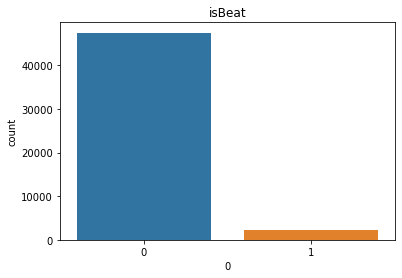

In [123]:
fig, ax = plt.subplots()
sns.countplot(x=0, data=auxBeats)
plt.title("isBeat")
plt.show()

In [124]:
auxBeats = pd.DataFrame(beatValues)
zero = auxBeats[auxBeats[0]=="0"].shape[0]
one = auxBeats[auxBeats[0]=="1"].shape[0]
print("Baseline :"+ str((zero/(one+zero))*100 )+" %")

Baseline :95.23399097322459 %


## Split the data

In [127]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=12345, stratify=y)
splitPoint = int(finalData.shape[0]*0.75)
X_train = finalData[:splitPoint][:][:]
X_test = finalData[splitPoint:][:][:]
y_train = beatValues[:splitPoint]
y_test = beatValues[splitPoint:]

#X_test, y_test = np.array(X_test), np.array(y_test)


## CNN MODEL

In [2]:
model = Sequential()

model.add(Conv1D(12, (3), activation='relu', input_shape=(23, 40)))
model.add(Conv1D(24, 3, activation='relu'))
model.add(Conv1D(32, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()

NameError: name 'Sequential' is not defined

In [132]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, batch_size=400, validation_split=0.2)

Train on 635575 samples, validate on 158894 samples
Epoch 1/100
635575/635575 [==============================] - 71s 112us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 2/100
635575/635575 [==============================] - 70s 111us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 3/100
635575/635575 [==============================] - 70s 111us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 4/100
635575/635575 [==============================] - 71s 111us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 5/100
635575/635575 [==============================] - 70s 111us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 6/100
635575/635575 [==============================] - 70s 111us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 7/100
635575/635575 [==============================] - 71s 111us/step - loss: 0.7595 - acc

Epoch 58/100
635575/635575 [==============================] - 70s 110us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 59/100
635575/635575 [==============================] - 70s 110us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 60/100
635575/635575 [==============================] - 70s 110us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 61/100
635575/635575 [==============================] - 70s 110us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 62/100
635575/635575 [==============================] - 70s 110us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 63/100
635575/635575 [==============================] - 71s 112us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507
Epoch 64/100
635575/635575 [==============================] - 72s 113us/step - loss: 0.7595 - acc: 0.9529 - val_loss: 0.7946 - val_acc: 0.9507

In [135]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

264824/264824 [==============================] - 15s 58us/step
Accuracy: 95.20%


In [136]:
model.save('Data/Spectrograms/Models/cnn_model.h5')

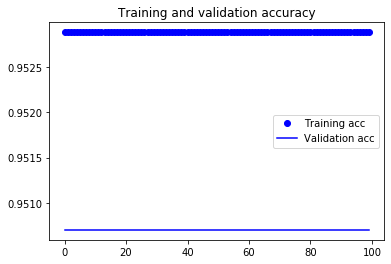

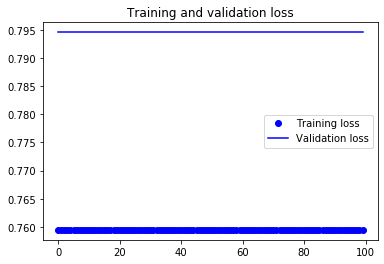

In [134]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()